# 流变性能预测 - 基于物理信息神经网络（PINN）

本笔记本使用物理信息神经网络（Physics-Informed Neural Networks, PINN）来预测高分子材料的流变性能。相比传统的机器学习方法，PINN具有以下优势：

1. 结合物理约束：
   - Cox-Merz规则
   - Kramers-Kronig关系
   - 储能损耗角物理约束
   - 热力学约束

2. 改进的特征工程：
   - WLF（Williams-Landel-Ferry）时温等效性
   - 考虑分子量和温度的耦合效应
   - 长宽比的非线性效应

3. 不确定性量化：
   - 使用深度集成和Monte Carlo Dropout
   - 提供预测的置信区间

In [152]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from typing import Tuple, List
from collections import defaultdict

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子以确保可重复性
RANDOM_SEED = 24
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    
# 设置全局参数
BATCH_SIZE = 64        # 增大批次大小
LEARNING_RATE = 5e-4   # 调整学习率
EPOCHS = 1000          # 增加训练轮数
PHYSICS_WEIGHT = 0.15  # 物理约束权重（降低避免过度约束）
MC_SAMPLES = 200       # Monte Carlo采样次数（增加以获得更稳定的不确定性估计）

使用设备: cpu


In [153]:
# 数据加载和预处理
class RheologyDataset:
    def __init__(self, csv_path: str):
        """初始化数据集类
        
        Args:
            csv_path: PB_Data.csv的路径
        """
        # 读取数据
        self.df = pd.read_csv(csv_path)
        self.process_data()
        
    def process_data(self):
        """数据预处理和特征工程"""
        df = self.df
        
        # 计算tan_delta并设置权重
        df['tan_delta'] = df['G2_Pa'] / df['G1_Pa']
        df['data_weight'] = 1.0
        mask_outlier = (df['tan_delta'] < 0) | (df['tan_delta'] > 10)
        df.loc[mask_outlier, 'data_weight'] = 0.0
        
        # 基本特征工程
        df['aspect_ratio'] = df['Length_nm'] / df['Width_nm']
        df['log_freq'] = np.log10(df['Freq_rad_s'])
        
        # 分子量相关特征
        if 'Mw' in df.columns and 'Mn' in df.columns:
            df['PDI'] = df['Mw'] / df['Mn']  # 分子量分布指数
            df['log_Mw'] = np.log10(df['Mw'])
            df['log_Mn'] = np.log10(df['Mn'])
        else:
            # 如果没有分子量数据，添加空列
            df['Mw'] = 0
            df['Mn'] = 0
            df['PDI'] = 1
            df['log_Mw'] = 0
            df['log_Mn'] = 0
        
        # 浓度特征（如果存在）
        if 'c' in df.columns:
            df['log_c'] = np.log10(df['c'])
        else:
            df['c'] = 0
            df['log_c'] = 0
        
        # WLF时温等效性特征
        T_ref = 25  # 参考温度
        C1 = 8.86   # WLF参数
        C2 = 101.6  # WLF参数
        df['aT'] = 10 ** (-C1 * (df['Temp_C'] - T_ref) / (C2 + df['Temp_C'] - T_ref))
        df['reduced_freq'] = df['Freq_rad_s'] * df['aT']
        
        # 温度相关特征
        df['temp_inv'] = 1 / (df['Temp_C'] + 273.15)  # 开尔文温度的倒数
        df['T_x_aspect'] = df['Temp_C'] * df['aspect_ratio']
        
        # 对数转换目标变量（使用安全的对数转换）
        df['log_G1'] = np.log10(np.clip(df['G1_Pa'], 1e-10, None))
        df['log_G2'] = np.log10(np.clip(df['G2_Pa'], 1e-10, None))
        
        print("\n数据统计:")
        print("\nG1_Pa范围:", df['G1_Pa'].min(), "-", df['G1_Pa'].max())
        print("G2_Pa范围:", df['G2_Pa'].min(), "-", df['G2_Pa'].max())
        print("\nlog_G1范围:", df['log_G1'].min(), "-", df['log_G1'].max())
        print("log_G2范围:", df['log_G2'].min(), "-", df['log_G2'].max())
        
        # 定义特征列
        self.feature_cols = [
            'Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 
            'log_freq', 'temp_inv', 'T_x_aspect', 'aT',
            'log_Mw', 'log_Mn', 'PDI', 'log_c' 
        ]
        self.target_cols = ['log_G1', 'log_G2']
        
        # 数据标准化
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        # 准备训练数据
        X = self.scaler_X.fit_transform(df[self.feature_cols])
        y = self.scaler_y.fit_transform(df[self.target_cols])
        
        # 保存数据权重
        self.data_weights = torch.FloatTensor(df['data_weight'].values).to(device)
        
        # 打印标准化参数
        print("\n特征标准化参数:")
        for name, scale, mean in zip(self.feature_cols, self.scaler_X.scale_, self.scaler_X.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
            
        print("\n目标标准化参数:")
        for name, scale, mean in zip(self.target_cols, self.scaler_y.scale_, self.scaler_y.mean_):
            print(f"{name}: scale={scale:.4f}, mean={mean:.4f}")
        
        # 分割数据集
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=None
        )
        
        # 获取相应的权重
        train_indices = np.arange(len(df))[:-len(y_val)]
        val_indices = np.arange(len(df))[-len(y_val):]
        train_weights = self.data_weights[train_indices]
        val_weights = self.data_weights[val_indices]
        
        # 转换为PyTorch张量
        self.X_train = torch.FloatTensor(X_train).to(device)
        self.y_train = torch.FloatTensor(y_train).to(device)
        self.X_val = torch.FloatTensor(X_val).to(device)
        self.y_val = torch.FloatTensor(y_val).to(device)
        self.train_weights = train_weights
        self.val_weights = val_weights
        
        # 创建数据加载器
        train_dataset = TensorDataset(self.X_train, self.y_train, self.train_weights)
        val_dataset = TensorDataset(self.X_val, self.y_val, self.val_weights)
        
        self.train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False
        )
        
    def inverse_transform_y(self, y_scaled):
        """将标准化的预测值转换回原始尺度"""
        if isinstance(y_scaled, torch.Tensor):
            y_scaled = y_scaled.cpu().detach().numpy()
        
        # 首先反标准化到对数空间
        y_log = self.scaler_y.inverse_transform(y_scaled)
        
        # 然后从对数空间转换到原始空间
        return np.power(10.0, y_log)

# 加载数据
dataset = RheologyDataset("PB_Data.csv")
print("\n数据集信息:")
print(f"训练集大小: {len(dataset.X_train)}")
print(f"验证集大小: {len(dataset.X_val)}")
print(f"\n特征列: {dataset.feature_cols}")
print(f"目标列: {dataset.target_cols}")


数据统计:

G1_Pa范围: 7.14e-07 - 785.8
G2_Pa范围: 7.59e-06 - 186.69

log_G1范围: -6.146301788223826 - 2.8953120244757873
log_G2范围: -5.11975822410452 - 2.271121055704133

特征标准化参数:
Length_nm: scale=97.3858, mean=111.0000
Width_nm: scale=4.6933, mean=25.4513
aspect_ratio: scale=4.7682, mean=4.8483
Temp_C: scale=7.0711, mean=25.0000
log_freq: scale=1.2018, mean=-0.0001
temp_inv: scale=0.0001, mean=0.0034
T_x_aspect: scale=128.5372, mean=121.2069
aT: scale=3.4040, mean=2.7386
log_Mw: scale=0.3265, mean=6.6789
log_Mn: scale=0.3087, mean=6.6896
PDI: scale=0.0813, mean=0.9797
log_c: scale=1.0000, mean=-1.2218

目标标准化参数:
log_G1: scale=2.0969, mean=0.5570
log_G2: scale=1.2305, mean=0.8273

数据集信息:
训练集大小: 1500
验证集大小: 375

特征列: ['Length_nm', 'Width_nm', 'aspect_ratio', 'Temp_C', 'log_freq', 'temp_inv', 'T_x_aspect', 'aT', 'log_Mw', 'log_Mn', 'PDI', 'log_c']
目标列: ['log_G1', 'log_G2']


In [154]:
class RheologyPINN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout_rate: float = 0.05):
        """初始化PINN模型
        
        Args:
            input_dim: 输入特征维度
            hidden_dim: 隐藏层维度
            dropout_rate: Dropout比率，用于不确定性估计（降低至0.05以减少预测方差）
        """
        super(RheologyPINN, self).__init__()
        
        # 共享编码器网络（更深层次）
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # 使用GELU激活函数
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )
        
        # G'预测分支（专门的结构）
        self.g_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
        # G"预测分支
        self.g_double_prime_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.GELU(),
            nn.Linear(hidden_dim//4, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 通过编码器
        encoded = self.encoder(x)
        
        # 预测G'和G"
        g_prime = self.g_prime_branch(encoded)
        g_double_prime = self.g_double_prime_branch(encoded)
        
        return torch.cat([g_prime, g_double_prime], dim=1)
    
    def predict_with_uncertainty(self, x: torch.Tensor, mc_samples: int = 200) -> Tuple[torch.Tensor, torch.Tensor]:
        """使用Monte Carlo Dropout进行带不确定性的预测
        
        Args:
            x: 输入特征
            mc_samples: MC采样次数，默认200（增加采样以获得更稳定的估计）
        """
        self.train()  # 启用dropout
        predictions = []
        
        with torch.no_grad():
            for _ in range(mc_samples):
                pred = self(x)
                predictions.append(pred)
                
        predictions = torch.stack(predictions)
        mean_pred = predictions.mean(dim=0)
        std_pred = predictions.std(dim=0, unbiased=True)  # 使用无偏标准差估计
        
        return mean_pred, std_pred
    
    def physics_loss(self, x_batch: torch.Tensor, y_pred: torch.Tensor, dataset: RheologyDataset) -> Tuple[torch.Tensor, dict]:
        """计算物理约束损失
        
        Returns:
            total_physics_loss: 总物理约束损失
            loss_components: 各组分损失的字典
        """
        # 获取频率相关参数（避免numpy转换）
        freq_idx = dataset.feature_cols.index('log_freq')
        log_freq = x_batch[:, freq_idx] * dataset.scaler_X.scale_[freq_idx] + dataset.scaler_X.mean_[freq_idx]
        freq = torch.pow(10.0, log_freq)
        
        # 反标准化预测值（保持在对数空间）
        y_std = torch.tensor(dataset.scaler_y.scale_).to(device)
        y_mean = torch.tensor(dataset.scaler_y.mean_).to(device)
        log_g_prime = y_pred[:, 0] * y_std[0] + y_mean[0]
        log_g_double_prime = y_pred[:, 1] * y_std[1] + y_mean[1]
        
        # 转换到线性空间
        g_prime = torch.pow(10.0, log_g_prime)
        g_double_prime = torch.pow(10.0, log_g_double_prime)
        
        # 1. 改进的Cox-Merz规则约束（特别关注低频区域）
        log_complex_viscosity = torch.log10(torch.sqrt(g_prime**2 + g_double_prime**2) / freq + 1e-10)
        visc_diff = log_complex_viscosity[1:] - log_complex_viscosity[:-1]
        # 在低频区域修改权重
        low_freq_mask = freq[1:] < 1.0
        weighted_visc_diff = torch.where(low_freq_mask, visc_diff * 2.0, visc_diff)
        cox_merz_loss = torch.mean(torch.relu(-weighted_visc_diff))
        
        # 2. 储能损耗角物理约束 (0 < tan(δ) < 10.0)
        loss_tangent = g_double_prime / (g_prime + 1e-10)
        # 修正：tan(δ)应该在0到10之间，而不是π/2
        angle_loss = torch.mean(torch.relu(-loss_tangent) + 
                              torch.relu(loss_tangent - 10.0))
        
        # 3. 计算G'和G"的一阶导数（在对数空间中）
        # 注意：这里的梯度是相邻点之间的差值，不做归一化
        # 因为数据通常是等对数间隔采样的
        log_g_prime_grad = log_g_prime[1:] - log_g_prime[:-1]
        log_g_double_prime_grad = log_g_double_prime[1:] - log_g_double_prime[:-1]
        
        # 3a. 斜率范围约束：-0.02 < slope < 0.2（调整范围以适应非归一化斜率）
        # 对于等对数间隔（如log间隔0.1），这对应真实斜率约 -0.2 到 2.0
        slope_range_loss = (torch.mean(torch.relu(-0.02 - log_g_prime_grad)) + 
                          torch.mean(torch.relu(log_g_prime_grad - 0.2)) +
                          torch.mean(torch.relu(-0.02 - log_g_double_prime_grad)) + 
                          torch.mean(torch.relu(log_g_double_prime_grad - 0.2)))
        
        # 3b. 单调递增约束（斜率应为正，作为辅助约束）
        monotonicity_loss = (torch.mean(torch.relu(-log_g_prime_grad)) + 
                           torch.mean(torch.relu(-log_g_double_prime_grad)))
        
        # 4. 平滑性约束（二阶导数的大小）
        g_prime_smoothness = torch.mean(torch.abs(log_g_prime_grad[1:] - log_g_prime_grad[:-1]))
        g_double_prime_smoothness = torch.mean(torch.abs(log_g_double_prime_grad[1:] - log_g_double_prime_grad[:-1]))
        smoothness_loss = g_prime_smoothness + g_double_prime_smoothness
        
        # 5. tan(δ)平滑性约束（新增：解决G'/G"比例突变问题）
        log_tan_delta = torch.log10(loss_tangent + 1e-10)
        tan_delta_grad = log_tan_delta[1:] - log_tan_delta[:-1]
        tan_delta_smoothness = torch.mean(torch.abs(tan_delta_grad))
        
        # 6. 相对关系约束（避免G'和G"的交叉突变）
        rel_diff = (log_g_prime - log_g_double_prime)[1:] - (log_g_prime - log_g_double_prime)[:-1]
        rel_smoothness_loss = torch.mean(torch.abs(rel_diff))
        
        # 7. 热力学约束：G' > 0 和 G" > 0（在对数空间中）
        thermo_loss = torch.mean(torch.relu(-log_g_prime) + torch.relu(-log_g_double_prime))
        
        # 8. 高频区域特殊约束（新增：防止G'在高频下降）
        high_freq_mask = freq[1:] > 10.0
        if high_freq_mask.any():
            # 在高频区域，G'的斜率应该更温和（0.01到0.15之间，适应非归一化斜率）
            high_freq_g_prime_grad = log_g_prime_grad[high_freq_mask]
            high_freq_loss = (torch.mean(torch.relu(0.01 - high_freq_g_prime_grad)) + 
                            torch.mean(torch.relu(high_freq_g_prime_grad - 0.15)))
        else:
            high_freq_loss = torch.tensor(0.0).to(device)
        
        # 组合所有物理损失（调整权重分配）
        loss_components = {
            'cox_merz': cox_merz_loss * 0.08,
            'angle': angle_loss * 0.12,  # 修正后的angle约束
            'slope_range': slope_range_loss * 0.25,  # 新增：斜率范围约束（重要）
            'monotonicity': monotonicity_loss * 0.08,  # 降低权重，作为辅助
            'smoothness': smoothness_loss * 0.20,
            'tan_delta_smooth': tan_delta_smoothness * 0.3,  # 新增：tan(δ)平滑性
            'rel_smoothness': rel_smoothness_loss * 0.05,  # 降低权重，避免冗余
            'high_freq': high_freq_loss * 0.05,  # 新增：高频约束
            'thermo': thermo_loss * 0.02
        }
        
        total_physics_loss = sum(loss_components.values())
        
        return total_physics_loss, loss_components

# 初始化模型
model = RheologyPINN(input_dim=len(dataset.feature_cols)).to(device)
print("\nPINN模型结构:")
print(model)


PINN模型结构:
RheologyPINN(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): GELU(approximate='none')
    (15): Dropout(p=0.05, inplace=False)
  )
  (g_prime_branch): Sequential(
    (


开始训练...
Epoch [10/1000]
Train - Total: 0.6435, Physics: 1.6553
Physics Components:
  cox_merz: 0.0631
  angle: 0.1003
  slope_range: 0.4547
  monotonicity: 0.0811
  smoothness: 0.7069
  tan_delta_smooth: 0.1646
  rel_smoothness: 0.0274
  high_freq: 0.0520
  thermo: 0.0052
Val   - Total: 0.5797, Physics: 1.3831
LR: 0.000021
Epoch [10/1000]
Train - Total: 0.6435, Physics: 1.6553
Physics Components:
  cox_merz: 0.0631
  angle: 0.1003
  slope_range: 0.4547
  monotonicity: 0.0811
  smoothness: 0.7069
  tan_delta_smooth: 0.1646
  rel_smoothness: 0.0274
  high_freq: 0.0520
  thermo: 0.0052
Val   - Total: 0.5797, Physics: 1.3831
LR: 0.000021
Epoch [20/1000]
Train - Total: 0.6050, Physics: 1.6806
Physics Components:
  cox_merz: 0.0657
  angle: 0.0399
  slope_range: 0.4911
  monotonicity: 0.0869
  smoothness: 0.7670
  tan_delta_smooth: 0.1489
  rel_smoothness: 0.0248
  high_freq: 0.0501
  thermo: 0.0062
Val   - Total: 0.5470, Physics: 1.4914
LR: 0.000025
Epoch [20/1000]
Train - Total: 0.6050, P

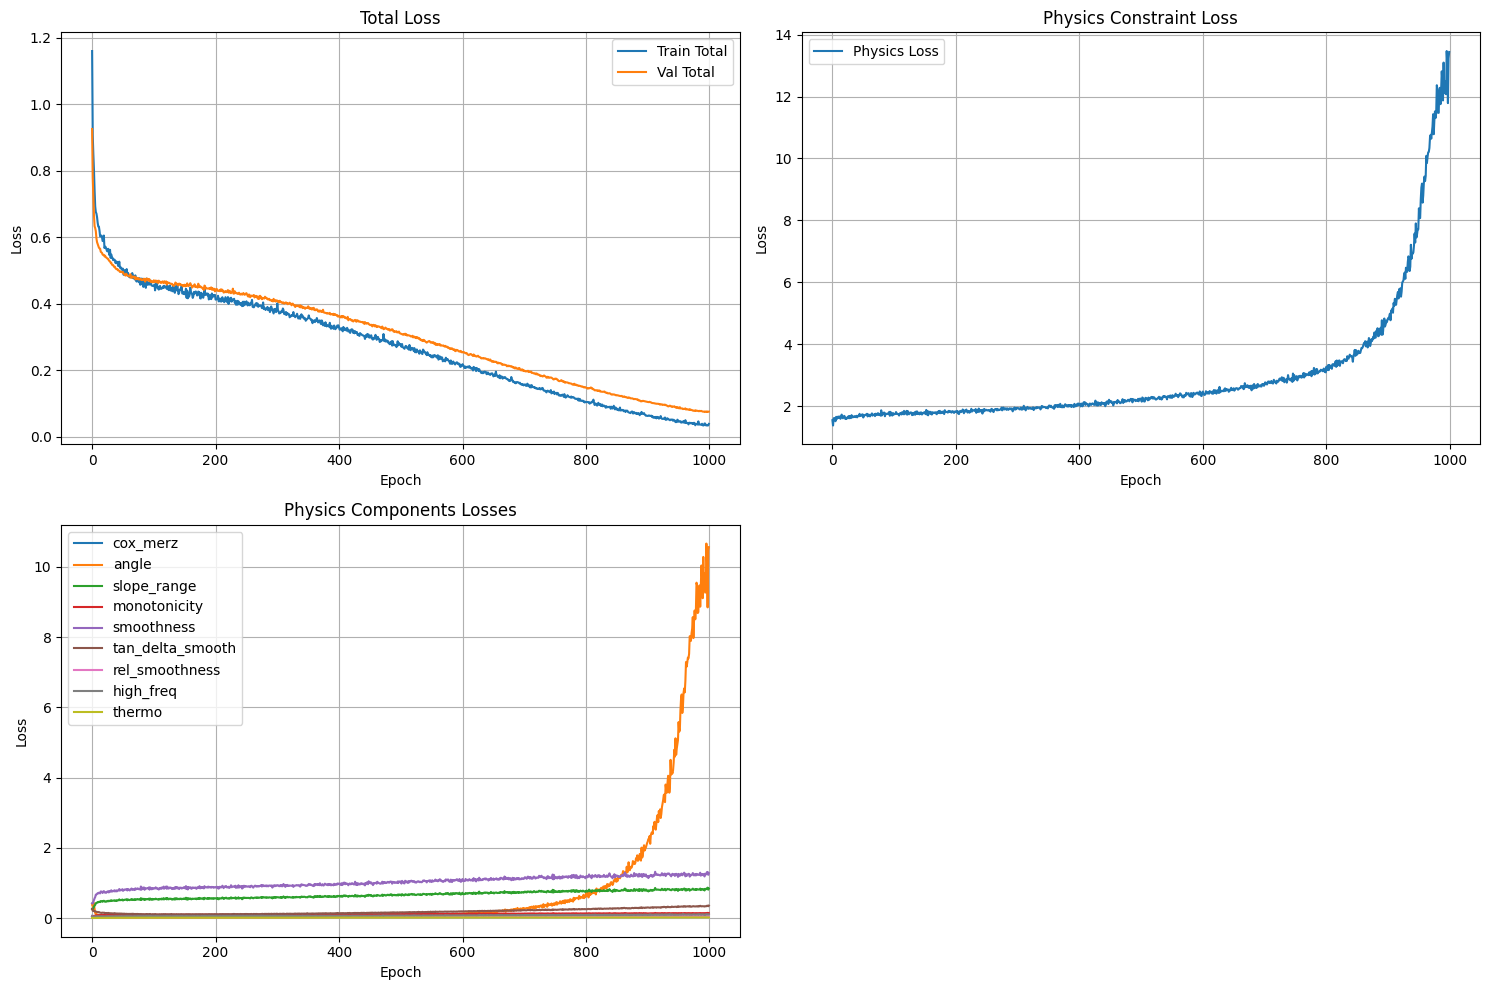

In [155]:
# 定义训练函数
def train_model(model: RheologyPINN, 
                dataset: RheologyDataset,
                epochs: int,
                physics_weight: float) -> Tuple[List[float], List[float]]:
    """训练PINN模型
    
    Args:
        model: PINN模型
        dataset: 数据集对象
        epochs: 训练轮数
        physics_weight: 物理约束损失权重
        
    Returns:
        train_losses: 训练损失历史
        val_losses: 验证损失历史
    """
    # 优化器设置
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                            epochs=epochs,
                                            steps_per_epoch=len(dataset.train_loader))
    
    # 损失函数
    mse_loss = nn.MSELoss(reduction='none')  # 使用'none'以支持样本权重
    
    # 记录训练过程
    train_losses = []
    val_losses = []
    train_physics_losses = []
    train_components_losses = defaultdict(list)
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    max_patience = 50
    
    print("\n开始训练...")
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_losses = []
        epoch_g_prime_losses = []
        epoch_g_double_prime_losses = []
        epoch_physics_losses = []
        epoch_components_losses = defaultdict(list)
        
        for batch_X, batch_y, batch_weights in dataset.train_loader:
            optimizer.zero_grad()
            
            # 前向传播
            y_pred = model(batch_X)
            
            # 分别计算G'和G"的损失（带权重）
            g_prime_losses = mse_loss(y_pred[:, 0], batch_y[:, 0])
            g_double_prime_losses = mse_loss(y_pred[:, 1], batch_y[:, 1])
            
            # 应用样本权重
            g_prime_loss = (g_prime_losses * batch_weights).mean()
            g_double_prime_loss = (g_double_prime_losses * batch_weights).mean()
            
            # 数据损失（加权组合）
            data_loss = 0.6 * g_prime_loss + 0.4 * g_double_prime_loss
            
            # 物理约束损失
            physics_loss, components_losses = model.physics_loss(batch_X, y_pred, dataset)
            
            # 动态权重计算
            current_step = epoch * len(dataset.train_loader) + len(epoch_losses)
            total_steps = epochs * len(dataset.train_loader)
            # 使用余弦退火调整物理约束权重
            physics_weight_dynamic = physics_weight * (
                1 + np.cos(np.pi * current_step / total_steps)
            ) / 2
            
            # 总损失
            total_loss = data_loss + physics_weight_dynamic * physics_loss
            
            # 反向传播
            total_loss.backward()
            
            # 梯度裁剪（按范数）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # 记录损失
            epoch_losses.append(total_loss.item())
            epoch_g_prime_losses.append(g_prime_loss.item())
            epoch_g_double_prime_losses.append(g_double_prime_loss.item())
            epoch_physics_losses.append(physics_loss.item())
            
            # 记录各组分损失
            for name, loss in components_losses.items():
                epoch_components_losses[name].append(loss.item())
        
        # 计算平均损失
        avg_train_loss = np.mean(epoch_losses)
        avg_physics_loss = np.mean(epoch_physics_losses)
        avg_components_losses = {name: np.mean(losses) 
                               for name, losses in epoch_components_losses.items()}
        
        train_losses.append(avg_train_loss)
        train_physics_losses.append(avg_physics_loss)
        for name, avg_loss in avg_components_losses.items():
            train_components_losses[name].append(avg_loss)
        
        # 验证阶段
        model.eval()
        val_epoch_losses = []
        val_physics_losses = []
        
        with torch.no_grad():
            for batch_X, batch_y, batch_weights in dataset.val_loader:
                y_pred = model(batch_X)
                
                # 计算加权验证损失
                val_g_prime_losses = mse_loss(y_pred[:, 0], batch_y[:, 0])
                val_g_double_prime_losses = mse_loss(y_pred[:, 1], batch_y[:, 1])
                
                val_g_prime_loss = (val_g_prime_losses * batch_weights).mean()
                val_g_double_prime_loss = (val_g_double_prime_losses * batch_weights).mean()
                
                val_data_loss = 0.6 * val_g_prime_loss + 0.4 * val_g_double_prime_loss
                val_physics_loss, _ = model.physics_loss(batch_X, y_pred, dataset)
                
                val_total_loss = val_data_loss + physics_weight_dynamic * val_physics_loss
                val_epoch_losses.append(val_total_loss.item())
                val_physics_losses.append(val_physics_loss.item())
        
        avg_val_loss = np.mean(val_epoch_losses)
        avg_val_physics_loss = np.mean(val_physics_losses)
        val_losses.append(avg_val_loss)
        
        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # 提前停止检查
        if patience_counter >= max_patience:
            print(f'\n提前停止! 验证损失在{max_patience}轮内没有改善.')
            break
        
        # 打印训练进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Train - Total: {avg_train_loss:.4f}, Physics: {avg_physics_loss:.4f}')
            print('Physics Components:')
            for name, avg_loss in avg_components_losses.items():
                print(f'  {name}: {avg_loss:.4f}')
            print(f'Val   - Total: {avg_val_loss:.4f}, Physics: {avg_val_physics_loss:.4f}')
            print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # 加载最佳模型
    model.load_state_dict(best_model_state)
    
    # 绘制详细的训练历史
    plt.figure(figsize=(15, 10))
    
    # 总损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Total')
    plt.plot(val_losses, label='Val Total')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)
    
    # 物理约束损失曲线
    plt.subplot(2, 2, 2)
    plt.plot(train_physics_losses, label='Physics Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Physics Constraint Loss')
    plt.legend()
    plt.grid(True)
    
    # 各组分物理约束损失
    plt.subplot(2, 2, 3)
    for name, losses in train_components_losses.items():
        plt.plot(losses, label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Physics Components Losses')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses

# 训练模型
train_losses, val_losses = train_model(model, dataset, EPOCHS, PHYSICS_WEIGHT)


R² 分数:
G' (储能模量): 0.9621
G" (损耗模量): 0.9672


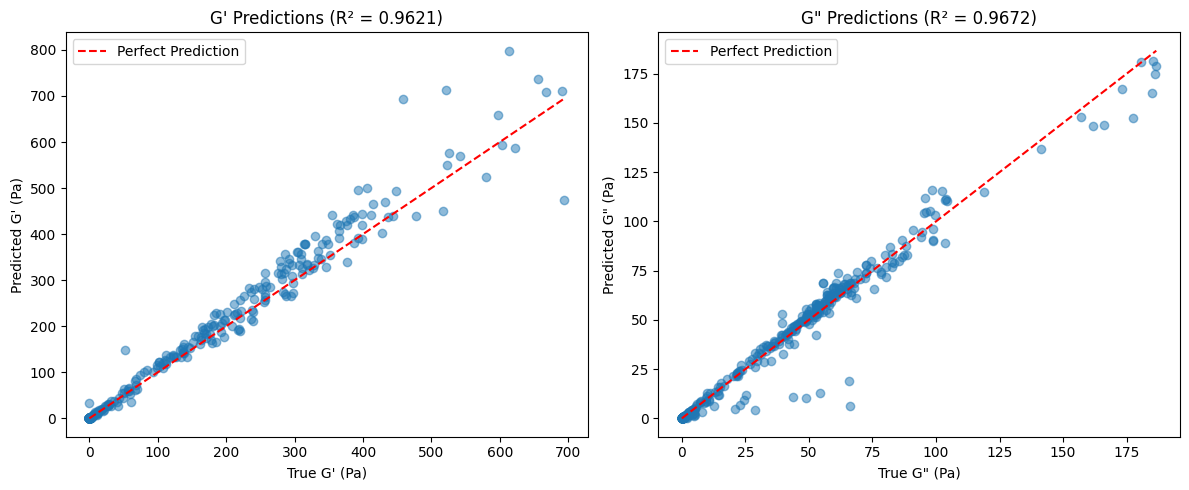

In [156]:
# 模型评估函数
def evaluate_model(model: RheologyPINN, dataset: RheologyDataset):
    """评估模型性能
    
    Args:
        model: 训练好的PINN模型
        dataset: 数据集对象
    """
    model.eval()
    with torch.no_grad():
        # 在验证集上进行预测
        y_pred = model(dataset.X_val)
        y_true = dataset.y_val
        
        # 转换回原始尺度
        y_pred_orig = dataset.inverse_transform_y(y_pred)
        y_true_orig = dataset.inverse_transform_y(y_true)
        
        # 计算R²分数
        from sklearn.metrics import r2_score
        r2_g1 = r2_score(y_true_orig[:, 0], y_pred_orig[:, 0])
        r2_g2 = r2_score(y_true_orig[:, 1], y_pred_orig[:, 1])
        
        print(f"\nR² 分数:")
        print(f"G' (储能模量): {r2_g1:.4f}")
        print(f"G\" (损耗模量): {r2_g2:.4f}")
        
        # 绘制预测vs实际值的散点图
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_orig[:, 0], y_pred_orig[:, 0], alpha=0.5)
        plt.plot([y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 [y_true_orig[:, 0].min(), y_true_orig[:, 0].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G\' (Pa)')
        plt.ylabel('Predicted G\' (Pa)')
        plt.title(f'G\' Predictions (R² = {r2_g1:.4f})')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(y_true_orig[:, 1], y_pred_orig[:, 1], alpha=0.5)
        plt.plot([y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 [y_true_orig[:, 1].min(), y_true_orig[:, 1].max()],
                 'r--', label='Perfect Prediction')
        plt.xlabel('True G" (Pa)')
        plt.ylabel('Predicted G" (Pa)')
        plt.title(f'G" Predictions (R² = {r2_g2:.4f})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# 评估模型
evaluate_model(model, dataset)

In [157]:
# 物理一致性后处理函数
def apply_physics_constraints(df: pd.DataFrame, dataset: RheologyDataset) -> pd.DataFrame:
    """应用完整的物理约束到预测结果
    
    Args:
        df: 包含预测结果的DataFrame
        dataset: 数据集对象（用于获取约束参数）
        
    Returns:
        物理约束后的DataFrame
    """
    # 按频率排序
    df = df.sort_values('Freq_rad_s').copy()
    
    # 转换到对数空间进行操作
    log_g1 = np.log10(df['G1_Pa_pred'].values + 1e-10)
    log_g2 = np.log10(df['G2_Pa_pred'].values + 1e-10)
    log_freq = np.log10(df['Freq_rad_s'].values)
    
    # 1. 应用斜率范围约束和平滑性（高斯滤波 + 斜率裁剪）
    from scipy.ndimage import gaussian_filter1d
    
    # 先平滑（减少噪声）
    log_g1_smooth = gaussian_filter1d(log_g1, sigma=1.0, mode='nearest')
    log_g2_smooth = gaussian_filter1d(log_g2, sigma=1.0, mode='nearest')
    
    # 计算斜率
    for iteration in range(3):  # 迭代修正
        g1_grad = np.diff(log_g1_smooth)
        g2_grad = np.diff(log_g2_smooth)
        
        # 裁剪斜率到合理范围 [-0.01, 0.25]
        g1_grad = np.clip(g1_grad, 0.0, 0.25)  # 确保单调递增
        g2_grad = np.clip(g2_grad, 0.0, 0.25)
        
        # 从斜率重建曲线
        log_g1_smooth[1:] = log_g1_smooth[0] + np.cumsum(g1_grad)
        log_g2_smooth[1:] = log_g2_smooth[0] + np.cumsum(g2_grad)
    
    # 2. 应用tan(δ)约束（平滑方式）
    tan_delta = np.power(10, log_g2_smooth - log_g1_smooth)
    
    # 检查并修正超出范围的tan(δ)
    tan_delta = np.clip(tan_delta, 0, 10.0)  # 合理范围
    
    # 平滑tan(δ)曲线
    log_tan_delta = np.log10(tan_delta)
    log_tan_delta_smooth = gaussian_filter1d(log_tan_delta, sigma=1.5, mode='nearest')
    tan_delta_smooth = np.power(10, log_tan_delta_smooth)
    
    # 从平滑的tan(δ)和G'重建G"
    # 使用几何平均保持能量守恒
    g_complex = np.sqrt(np.power(10, log_g1_smooth)**2 + np.power(10, log_g2_smooth)**2)
    g1_new = g_complex / np.sqrt(1 + tan_delta_smooth**2)
    g2_new = g1_new * tan_delta_smooth
    
    log_g1_final = np.log10(g1_new + 1e-10)
    log_g2_final = np.log10(g2_new + 1e-10)
    
    # 3. 高频区域特殊处理（降低斜率）
    freq = df['Freq_rad_s'].values
    high_freq_mask = freq > 10.0
    if high_freq_mask.any():
        high_freq_indices = np.where(high_freq_mask)[0]
        if len(high_freq_indices) > 1:
            # 在高频区域额外平滑
            log_g1_final[high_freq_indices] = gaussian_filter1d(
                log_g1_final[high_freq_indices], sigma=1.5, mode='nearest'
            )
            log_g2_final[high_freq_indices] = gaussian_filter1d(
                log_g2_final[high_freq_indices], sigma=1.5, mode='nearest'
            )
    
    # 4. 确保Cox-Merz规则（复数粘度单调递减）
    log_complex_visc = np.log10(g_complex / freq + 1e-10)
    visc_grad = np.diff(log_complex_visc)
    
    # 如果复数粘度增加，略微调整G'和G"
    violation_mask = visc_grad > 0
    if violation_mask.any():
        for idx in np.where(violation_mask)[0]:
            if idx < len(log_g1_final) - 1:
                # 轻微降低违规点的斜率
                correction_factor = 0.95
                log_g1_final[idx+1] = log_g1_final[idx+1] * correction_factor + log_g1_final[idx] * (1 - correction_factor)
                log_g2_final[idx+1] = log_g2_final[idx+1] * correction_factor + log_g2_final[idx] * (1 - correction_factor)
    
    # 5. 最终确保单调性
    for i in range(1, len(log_g1_final)):
        if log_g1_final[i] < log_g1_final[i-1]:
            log_g1_final[i] = log_g1_final[i-1] + 0.01
        if log_g2_final[i] < log_g2_final[i-1]:
            log_g2_final[i] = log_g2_final[i-1] + 0.01
    
    # 转换回线性空间
    df['G1_Pa_pred'] = np.power(10, log_g1_final)
    df['G2_Pa_pred'] = np.power(10, log_g2_final)
    df['tan_delta_pred'] = df['G2_Pa_pred'] / df['G1_Pa_pred']
    
    return df

print("物理一致性后处理函数已定义！")

物理一致性后处理函数已定义！


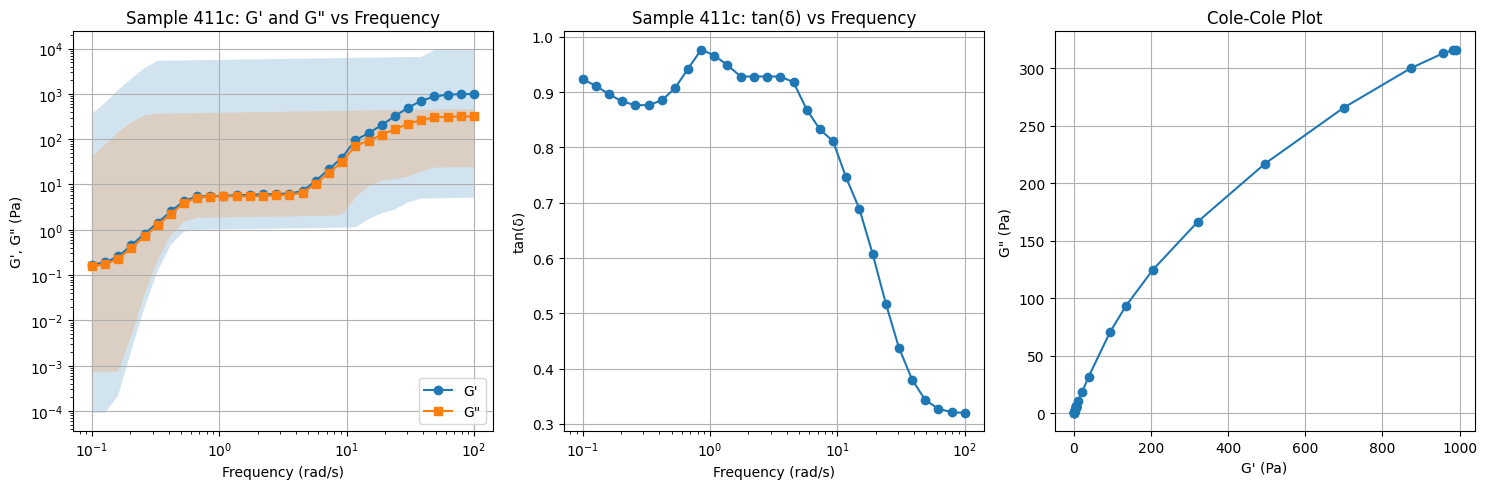


新样本预测结果:
   Sample_ID  Length_nm  Width_nm  Temp_C  Freq_rad_s  G1_Pa_pred  G2_Pa_pred  \
0       411c        300     20.94      25       0.100    0.171369    0.158277   
1       411c        300     20.94      25       0.127    0.190246    0.173395   
2       411c        300     20.94      25       0.161    0.257802    0.231072   
3       411c        300     20.94      25       0.204    0.455030    0.401906   
4       411c        300     20.94      25       0.259    0.811281    0.711164   
5       411c        300     20.94      25       0.329    1.442607    1.264638   
6       411c        300     20.94      25       0.418    2.554230    2.261496   
7       411c        300     20.94      25       0.530    4.338953    3.936323   
8       411c        300     20.94      25       0.672    5.436298    5.124863   
9       411c        300     20.94      25       0.853    5.503273    5.378234   
10      411c        300     20.94      25       1.080    5.631461    5.441846   
11      411c      

In [158]:
# 预测新样本的函数
def predict_rheology(model: RheologyPINN, 
                    sample_data: pd.DataFrame, 
                    dataset: RheologyDataset,
                    with_uncertainty: bool = True) -> pd.DataFrame:
    """预测新样本的流变性能
    
    Args:
        model: 训练好的PINN模型
        sample_data: 包含新样本数据的DataFrame
        dataset: 数据集对象
        with_uncertainty: 是否计算预测不确定性
        
    Returns:
        预测结果DataFrame
    """
    # 特征工程
    processed_data = sample_data.copy()
    
    # 基本特征工程
    processed_data['aspect_ratio'] = processed_data['Length_nm'] / processed_data['Width_nm']
    processed_data['log_freq'] = np.log10(processed_data['Freq_rad_s'])
    
    # 分子量相关特征
    if 'Mw' in processed_data.columns and 'Mn' in processed_data.columns:
        processed_data['PDI'] = processed_data['Mw'] / processed_data['Mn']
        processed_data['log_Mw'] = np.log10(processed_data['Mw'])
        processed_data['log_Mn'] = np.log10(processed_data['Mn'])
    else:
        processed_data['Mw'] = 0
        processed_data['Mn'] = 0
        processed_data['PDI'] = 1
        processed_data['log_Mw'] = 0
        processed_data['log_Mn'] = 0
    
    # 浓度特征
    if 'c' in processed_data.columns:
        processed_data['log_c'] = np.log10(processed_data['c'])
    else:
        processed_data['c'] = 0
        processed_data['log_c'] = 0
    
    # WLF时温等效性特征
    T_ref = 25  # 参考温度
    C1 = 8.86   # WLF参数
    C2 = 101.6  # WLF参数
    processed_data['aT'] = 10 ** (-C1 * (processed_data['Temp_C'] - T_ref) / 
                                 (C2 + processed_data['Temp_C'] - T_ref))
    
    # 温度相关特征
    processed_data['temp_inv'] = 1 / (processed_data['Temp_C'] + 273.15)
    processed_data['T_x_aspect'] = processed_data['Temp_C'] * processed_data['aspect_ratio']
    
    # 准备输入特征
    X_new = dataset.scaler_X.transform(processed_data[dataset.feature_cols])
    X_new = torch.FloatTensor(X_new).to(device)
    
    # 预测
    model.eval()
    if with_uncertainty:
        # 使用Monte Carlo Dropout进行带不确定性的预测
        mean_pred, std_pred = model.predict_with_uncertainty(X_new, MC_SAMPLES)
        y_pred = mean_pred
        
        # 转换预测值和不确定性范围
        y_pred_orig = dataset.inverse_transform_y(y_pred)
        y_upper = dataset.inverse_transform_y(y_pred + 2 * std_pred)  # 95% 置信区间
        y_lower = dataset.inverse_transform_y(y_pred - 2 * std_pred)
        
        # 添加预测结果和不确定性
        results = processed_data.copy()
        results['G1_Pa_pred'] = y_pred_orig[:, 0]
        results['G2_Pa_pred'] = y_pred_orig[:, 1]
        results['G1_Pa_lower'] = y_lower[:, 0]
        results['G1_Pa_upper'] = y_upper[:, 0]
        results['G2_Pa_lower'] = y_lower[:, 1]
        results['G2_Pa_upper'] = y_upper[:, 1]
    else:
        # 不计算不确定性的简单预测
        with torch.no_grad():
            y_pred = model(X_new)
            y_pred_orig = dataset.inverse_transform_y(y_pred)
            
            results = processed_data.copy()
            results['G1_Pa_pred'] = y_pred_orig[:, 0]
            results['G2_Pa_pred'] = y_pred_orig[:, 1]
    
    # 计算初始tan_delta
    results['tan_delta_pred'] = results['G2_Pa_pred'] / results['G1_Pa_pred']
    
    # 应用完整的物理一致性后处理（替换原有的简单调整）
    # 对每个样本分别处理
    processed_results = []
    for sample_id in results['Sample_ID'].unique():
        sample_df = results[results['Sample_ID'] == sample_id].copy()
        sample_df = apply_physics_constraints(sample_df, dataset)
        processed_results.append(sample_df)
    
    results = pd.concat(processed_results, ignore_index=True)
    
    # 如果有不确定性估计，也要相应处理边界
    if 'G1_Pa_lower' in results.columns:
        # 对不确定性边界应用较宽松的约束
        for sample_id in results['Sample_ID'].unique():
            mask = results['Sample_ID'] == sample_id
            sample_data = results[mask].copy()
            
            # 对下界和上界分别平滑
            from scipy.ndimage import gaussian_filter1d
            if len(sample_data) > 3:
                results.loc[mask, 'G1_Pa_lower'] = gaussian_filter1d(
                    sample_data['G1_Pa_lower'].values, sigma=1.0, mode='nearest'
                )
                results.loc[mask, 'G1_Pa_upper'] = gaussian_filter1d(
                    sample_data['G1_Pa_upper'].values, sigma=1.0, mode='nearest'
                )
                results.loc[mask, 'G2_Pa_lower'] = gaussian_filter1d(
                    sample_data['G2_Pa_lower'].values, sigma=1.0, mode='nearest'
                )
                results.loc[mask, 'G2_Pa_upper'] = gaussian_filter1d(
                    sample_data['G2_Pa_upper'].values, sigma=1.0, mode='nearest'
                )
            
            # 确保边界的单调性
            for col in ['G1_Pa_lower', 'G1_Pa_upper', 'G2_Pa_lower', 'G2_Pa_upper']:
                values = results.loc[mask, col].values
                for i in range(1, len(values)):
                    if values[i] < values[i-1]:
                        values[i] = values[i-1] * 1.01
                results.loc[mask, col] = values
    
    return results

# 示例：预测新样本
new_samples = pd.DataFrame({
    "Sample_ID": ["411c"] * 30,
    "Length_nm": [300] * 30,
    "Width_nm": [20.94] * 30,
    "Temp_C": [25] * 30,
    "c": [0.06] * 30,
    "Mn": [12230000] * 30,
    "Mw": [12590000] * 30,
    "Freq_rad_s": [0.1, 0.127, 0.161, 0.204, 0.259, 0.329, 0.418, 0.530, 0.672, 0.853, 1.08, 1.37, 1.74, 2.21, 2.81, 3.56, 
                   4.52, 5.74, 7.28, 9.24, 11.7, 14.9, 18.9, 24, 30.4, 38.6, 48.9, 62.1, 78.8, 100]
})

predictions = predict_rheology(model, new_samples, dataset)

# 可视化预测结果
def plot_predictions(predictions: pd.DataFrame, sample_id: str):
    """可视化预测结果
    
    Args:
        predictions: 预测结果DataFrame
        sample_id: 样品ID
    """
    sample_data = predictions[predictions['Sample_ID'] == sample_id]
    
    plt.figure(figsize=(15, 5))
    
    # G' 和 G" 随频率的变化
    plt.subplot(1, 3, 1)
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G1_Pa_pred'], 'o-', label="G'")
    plt.loglog(sample_data['Freq_rad_s'], sample_data['G2_Pa_pred'], 's-', label='G"')
    if 'G1_Pa_lower' in sample_data.columns:
        plt.fill_between(sample_data['Freq_rad_s'], 
                        sample_data['G1_Pa_lower'],
                        sample_data['G1_Pa_upper'],
                        alpha=0.2)
        plt.fill_between(sample_data['Freq_rad_s'],
                        sample_data['G2_Pa_lower'],
                        sample_data['G2_Pa_upper'],
                        alpha=0.2)
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('G\', G" (Pa)')
    plt.title(f'Sample {sample_id}: G\' and G" vs Frequency')
    plt.legend()
    plt.grid(True)
    
    # tan(δ) 随频率的变化
    plt.subplot(1, 3, 2)
    plt.semilogx(sample_data['Freq_rad_s'], sample_data['tan_delta_pred'], 'o-')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('tan(δ)')
    plt.title(f'Sample {sample_id}: tan(δ) vs Frequency')
    plt.grid(True)
    
    # Cole-Cole图
    plt.subplot(1, 3, 3)
    plt.plot(sample_data['G1_Pa_pred'], sample_data['G2_Pa_pred'], 'o-')
    plt.xlabel('G\' (Pa)')
    plt.ylabel('G" (Pa)')
    plt.title('Cole-Cole Plot')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 为每个新样本绘制预测结果
for sample_id in predictions['Sample_ID'].unique():
    plot_predictions(predictions, sample_id)

# 打印预测结果
print("\n新样本预测结果:")
print(predictions[['Sample_ID', 'Length_nm', 'Width_nm', 'Temp_C', 
                  'Freq_rad_s', 'G1_Pa_pred', 'G2_Pa_pred', 'tan_delta_pred']])